In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold,
                                     KFold,
                                     cross_val_score,
                                     GridSearchCV)

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (confusion_matrix,
                            ConfusionMatrixDisplay,
                            precision_score,
                            recall_score,
                            accuracy_score)

In [2]:
# IN ORDER TO CENTER ALL GRAPHS 
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
# IN ORDER TO SUPRESS SOME WARNING WHILE USING KNN 
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# <center>Tasks</center>

<center><img src="Images/Assignment_2_Tasks.png" width="600" title="Tasks"></center>

# <center>Tratamento de Dados</center>

In [4]:
df = pd.read_csv('video_games.csv')
len(df.columns) + 4

19

In [5]:
# DataFrame 
df.head(3)

,id,name,category,n_dlcs,n_expansions,year,follows,in_franchise,genres,companies,platforms,user_score,user_rating,n_user_reviews,summary
0,1020,Grand Theft Auto V,main_game,0,0,2013,1766,True,"Shooter, Adventure","Rockstar North, Rockstar Games, Take-Two Inter...","PC (Microsoft Windows), PlayStation 3, Xbox 36...",90.202388,great,3369,Grand Theft Auto V is a vast open world game s...
1,1942,The Witcher 3: Wild Hunt,main_game,4,2,2015,1516,True,"Role-playing (RPG), Adventure","WB Games, Bandai Namco Entertainment, cdp.pl, ...","PC (Microsoft Windows), PlayStation 4, Xbox On...",95.169577,great,2997,"RPG and sequel to The Witcher 2 (2011), The Wi..."
2,472,The Elder Scrolls V: Skyrim,main_game,3,0,2011,1046,False,"Role-playing (RPG), Adventure","Bethesda Game Studios, Bethesda Softworks","PC (Microsoft Windows), PlayStation 3, Xbox 360",87.508504,great,2567,Skyrim reimagines and revolutionizes the open-...


In [6]:
# Info do DataFrame 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5824 non-null   int64  
 1   name            5824 non-null   object 
 2   category        5824 non-null   object 
 3   n_dlcs          5824 non-null   int64  
 4   n_expansions    5824 non-null   int64  
 5   year            5824 non-null   int64  
 6   follows         5824 non-null   int64  
 7   in_franchise    5824 non-null   bool   
 8   genres          5803 non-null   object 
 9   companies       5781 non-null   object 
 10  platforms       5824 non-null   object 
 11  user_score      5824 non-null   float64
 12  user_rating     5824 non-null   object 
 13  n_user_reviews  5824 non-null   int64  
 14  summary         5816 non-null   object 
dtypes: bool(1), float64(1), int64(6), object(7)
memory usage: 642.8+ KB


In [7]:
# Atributos que apresentam NaN values 
print(f"Atributo\t  Contem NaN?\n")
print(df.isna().any())
print(f"\nNº de NaN Values: {(df.isna().sum()).sum()}")
print(f"Nº de Null Values: {(df.isnull().sum()).sum()}")

Atributo	  Contem NaN?

id                False
name              False
category          False
n_dlcs            False
n_expansions      False
year              False
follows           False
in_franchise      False
genres             True
companies          True
platforms         False
user_score        False
user_rating       False
n_user_reviews    False
summary            True
dtype: bool

Nº de NaN Values: 72
Nº de Null Values: 72


In [8]:
# Remoção de Valores Repetidos ou NaN 

# Dado a quantidade reduzida de valores NaN e Null
# (face às ~6000 entradas do dataset),
# podemos remover as entradas correspondentes,
# visto não ir afetar a performance dos modelos preditivos

df.drop_duplicates(inplace=True)
df.dropna(how='any', axis=0, inplace=True)

In [9]:
# Conversão de Str to List de Alguns Atributos 

Attributes_Str_To_List = ['genres', 'companies', 'platforms']
for i in Attributes_Str_To_List:
    df[i] = df[i].str.split(", ")

for k in Attributes_Str_To_List:
    print(f"\t\tAttribute: {k}\n")
    print(df[k].head(3))
    print()

		Attribute: genres

0               [Shooter, Adventure]
1    [Role-playing (RPG), Adventure]
2    [Role-playing (RPG), Adventure]
Name: genres, dtype: object

		Attribute: companies

0    [Rockstar North, Rockstar Games, Take-Two Inte...
1    [WB Games, Bandai Namco Entertainment, cdp.pl,...
2          [Bethesda Game Studios, Bethesda Softworks]
Name: companies, dtype: object

		Attribute: platforms

0    [PC (Microsoft Windows), PlayStation 3, Xbox 3...
1    [PC (Microsoft Windows), PlayStation 4, Xbox O...
2    [PC (Microsoft Windows), PlayStation 3, Xbox 360]
Name: platforms, dtype: object



In [10]:
# Conversão do Atributo 'In_Franchise' para int 
# (True -> 1 || False -> 0)

atr = "in_franchise"
df[atr] = df[atr].apply(lambda x: x==True).astype('int64')
df[atr].head(3)

0    1
1    1
2    0
Name: in_franchise, dtype: int64

In [11]:
# NEW ATTRIBUTE -> AGE
# Este atributo corresponde à diferença do ano de lançamento com o ano atual (2023)
df.insert(2, 'age', 2023-df['year'])

In [12]:
# NEW ATTRIBUTE -> N_GENRES
# Este atributo corresponde ao comprimento da lista de géneros
df.insert(3, 'n_genres', df['genres'].apply(lambda x: len(x)))

In [13]:
# NEW ATTRIBUTE -> N_COMPANIES
# Este atributo corresponde ao comprimento da lista de empresas
df.insert(4, 'n_companies', df['companies'].apply(lambda x: len(x)))

In [14]:
# NEW ATTRIBUTE -> N_PLATFORMS
# Este atributo corresponde ao comprimento da lista de plataformas
df.insert(5, 'n_platforms', df['platforms'].apply(lambda x: len(x)))
df.head(3)

,id,name,age,n_genres,n_companies,n_platforms,category,n_dlcs,n_expansions,year,follows,in_franchise,genres,companies,platforms,user_score,user_rating,n_user_reviews,summary
0,1020,Grand Theft Auto V,10,2,3,7,main_game,0,0,2013,1766,1,"[Shooter, Adventure]","[Rockstar North, Rockstar Games, Take-Two Inte...","[PC (Microsoft Windows), PlayStation 3, Xbox 3...",90.202388,great,3369,Grand Theft Auto V is a vast open world game s...
1,1942,The Witcher 3: Wild Hunt,8,2,6,4,main_game,4,2,2015,1516,1,"[Role-playing (RPG), Adventure]","[WB Games, Bandai Namco Entertainment, cdp.pl,...","[PC (Microsoft Windows), PlayStation 4, Xbox O...",95.169577,great,2997,"RPG and sequel to The Witcher 2 (2011), The Wi..."
2,472,The Elder Scrolls V: Skyrim,12,2,2,3,main_game,3,0,2011,1046,0,"[Role-playing (RPG), Adventure]","[Bethesda Game Studios, Bethesda Softworks]","[PC (Microsoft Windows), PlayStation 3, Xbox 360]",87.508504,great,2567,Skyrim reimagines and revolutionizes the open-...


In [15]:
# De forma a avaliar a Avaliar
# a necessidade dos atributos para os modelos preditivos,
# recorreu-se a uma matriz de correlação

corr_df = df.corr()
corr_df.loc[((corr_df.values < -0.95) & (corr_df.values > -1.0)) |
           ((corr_df.values > 0.95) & (corr_df.values < 1.0))]

# Os atributos 'age' e 'year' apresentam uma correlação de -1.0, pelo
# que apresentam uma correlação negativa perfeita
# Assim, estes atributos acabam por ser inversamente proporcionais, 
# pelo que não acrescentam informação nova aod DataFrame. Consequentemente,
# é fulcral remover apenas um destes

,id,age,n_genres,n_companies,n_platforms,n_dlcs,n_expansions,year,follows,in_franchise,user_score,n_user_reviews
age,-0.428662,1.0,-0.255507,0.269817,0.145652,-0.15927,-0.028846,-1.0,-0.096327,0.157911,-0.006355,-0.039347
year,0.428662,-1.0,0.255507,-0.269817,-0.145652,0.15927,0.028846,1.0,0.096327,-0.157911,0.006355,0.039347


In [16]:
# Remoção de Colunas Desnecessárias 

del df["summary"]
del df["id"]
del df["category"]
del df['user_score']

# Nenhum dos atributos categóricos (exceto o 'user_rating') 
# será usado, pelo que podem ser removidos
del df['genres']
del df['companies']
del df['platforms']

# Atributo visto anteriormente
del df['year']

# O index passa a ser o atributo 'name'
df.set_index('name', inplace=True)
df.head(3)

,age,n_genres,n_companies,n_platforms,n_dlcs,n_expansions,follows,in_franchise,user_rating,n_user_reviews
name,,,,,,,,,,
Grand Theft Auto V,10,2,3,7,0,0,1766,1,great,3369
The Witcher 3: Wild Hunt,8,2,6,4,4,2,1516,1,great,2997
The Elder Scrolls V: Skyrim,12,2,2,3,3,0,1046,0,great,2567


In [17]:
# Agrupamento/Categorização dos Atributos 
# Categorical Columns/Attributes
cat_columns = ['user_rating']

# Numerical Columns/Attributes
num_columns = ['n_dlcs',
               'age',
               'n_expansions',
               'follows',
               'n_genres',
               'in_franchise',
               'n_companies',
               'n_platforms',
               'n_user_reviews']
df.dtypes

age                int64
n_genres           int64
n_companies        int64
n_platforms        int64
n_dlcs             int64
n_expansions       int64
follows            int64
in_franchise       int64
user_rating       object
n_user_reviews     int64
dtype: object


## <center>Visualização de Dados</center>

<AxesSubplot:xlabel='age', ylabel='n_user_reviews'>

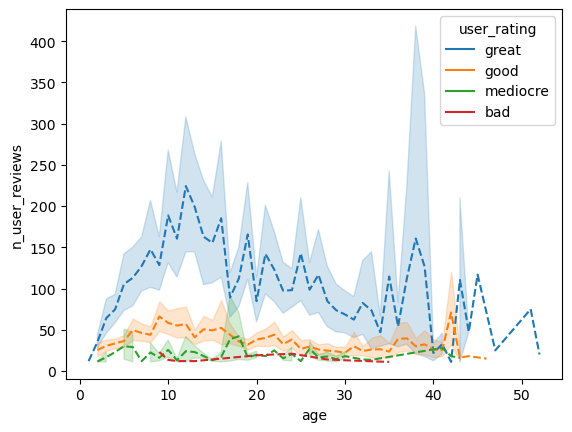

In [18]:
# Lineplot (n_user_reviews / age)
sns.lineplot(data=df,
             x='age',
             y='n_user_reviews',
             hue='user_rating',
             linestyle='--')

# Através deste gráfico é-nos possível identificar 
# a tendência de que jogos com uma maior quantidade
# de reviews tendem a ter uma melhor classifição

# Mais ainda, facilmente é possível observar que
# jogos mais recemtes tendem a ter uma melhor classificação
# e uma maior quantidade de reviews

<AxesSubplot:xlabel='age', ylabel='n_expansions'>

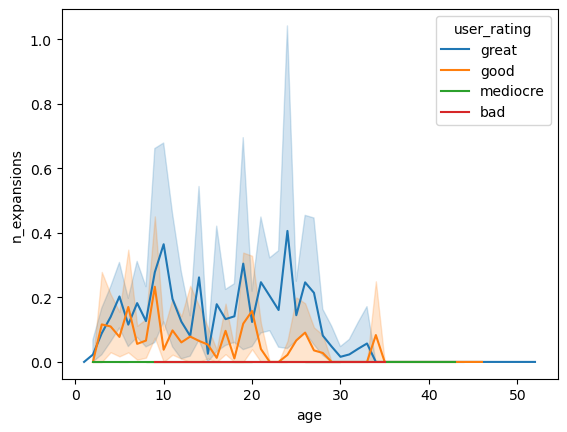

In [19]:
# Lineplot (n_expansions / age)
sns.lineplot(data=df,
             x='age',
             y='n_expansions',
             hue='user_rating')

# Através deste gráfico é-nos possível identificar 
# a tendência de que apenas os jogos classificados como 'great'
# ou 'good' recebem expansões para os respetivos jogos-base (standard-game) 

# <center> Análise e Criação de Modelos Preditivos </center>

## <center>Funções Auxiliares</center>

In [20]:
# Generic Functions to Analyse the Predictive Models

# Function to Save any DT model into a graph
def Save_Tree_Diagram(File_Name, Model):
    with open(f'Images/{File_Name}.dot', 'w') as out_file:
        out_file = tree.export_graphviz(Model, out_file=out_file)

# K-Fold Cross Validation Functions
def Get_Model_K_Fold_CV_Accuracies(model,X,Y):
    # cross_val_score returns a list of the scores, which we can visualize
    # to get a reasonable estimate of our classifier's performance
    kfold = KFold(n_splits=10)
    model_cross_validation_scores = cross_val_score(model,X,Y,cv=kfold)
    return model_cross_validation_scores

def Plot_Model_K_Fold_Cross_Validation(model_name, model,X,Y,color):
    model_cross_validation_scores = Get_Model_K_Fold_CV_Accuracies(model,X,Y)
    print(f"-> {model_name} Accuracy Avg: {model_cross_validation_scores.mean()*100:.3f} (Std: {model_cross_validation_scores.std()*100:.3f})\n")
    plt.hist(model_cross_validation_scores, color=color)
    plt.title(f'{model_name} -> Average Accuracy (%): {np.mean(model_cross_validation_scores)*100: .5f}')
    plt.grid(visible=True, linestyle='dashed', linewidth=1.2)
    plt.show()
    return model_cross_validation_scores

# Confusion Matrix
def Plot_Confusion_Matrix(Test_Values, Predicted_Values, labels):
    Confusion_Matrix = confusion_matrix(Test_Values,
                                        Predicted_Values,
                                        labels=labels)
    Display = ConfusionMatrixDisplay(confusion_matrix=Confusion_Matrix,
                                    display_labels=labels)
    Display.plot(cmap=plt.cm.Blues)
    plt.show()

In [21]:
# Functions to get the best classifier for each algorithm
def Find_Best_DT_Classifier(X,Y,stratigy=None):
    # stratigy - way to evaluate the performance of the cross-validated model on the test set
    DT_classifier = DecisionTreeClassifier()
    parameter_grid = {'criterion': ['gini', 'entropy'],
                      'splitter': ['best', 'random'],
                      'max_depth':[1,2,3,4,5],
                     'max_features':[1,2,3,4]}

    cross_validation = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(DT_classifier,
                              param_grid=parameter_grid,
                              cv=cross_validation,
                              scoring=stratigy)

    grid_search.fit(X,Y)
    print(f"Best Score (%):\n  -> {grid_search.best_score_*100:.4f}")

    print(f"Best Parameters:")
    for param in grid_search.best_params_:
        print(f"  -> {param} = {grid_search.best_params_[param]}")
    
    DT_classifier = grid_search.best_estimator_
    return DT_classifier

def Find_Best_KNN_Classifier(X, Y, num_neighbors, stratigy=None):
    KNN_Classifier = KNeighborsClassifier(n_neighbors=num_neighbors)
    parameter_grid = {'n_neighbors': (1,10, 1),
                      'leaf_size': (20,40,1),
                      'p': (1,2),
                      'weights': ('uniform', 'distance'),
                      'metric': ('minkowski', 'chebyshev')},

    cross_validation = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(KNN_Classifier,
                              param_grid=parameter_grid,
                              cv=cross_validation,
                              scoring=stratigy)

    grid_search.fit(X,Y)
    print(f"Best Score (%):\n  -> {grid_search.best_score_*100:.4f}")
    print(f"Best Parameters:")
    for param in grid_search.best_params_:
        print(f"  -> {param} = {grid_search.best_params_[param]}")
    
    KNN_Classifier = grid_search.best_estimator_
    return KNN_Classifier


## <center>Previsão do 'User_Rating' (Decision Tree & KNN) </center>

### - Criação de subsets para treino e teste de modelos preditivos

In [22]:
X = df[num_columns]
Y = df['user_rating']

(X_train, X_test,
 Y_train, Y_test) = train_test_split(X, Y, test_size=0.3)

## <center>Decision Tree Classifier</center>

In [23]:
# Decision Tree Classifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
;

''

In [24]:
# Decision Tree - Test Predictions
decision_tree_predicted = decision_tree.predict(X_test)
total_guesses = decision_tree_predicted.shape[0]
correct_guesses = ((decision_tree_predicted == Y_test) == True).sum()
incorrect_guesses = ((decision_tree_predicted == Y_test) == False).sum()

print(f"Previsões Corretas: {correct_guesses}/{total_guesses}")
print(f"Previsões Incorretas: {incorrect_guesses}/{total_guesses}")

Previsões Corretas: 1016/1726
Previsões Incorretas: 710/1726


In [25]:
# Decision Tree - Train and Test Accuracies

decision_tree_acc_train = decision_tree.score(X_train, Y_train)
decision_tree_acc_test = decision_tree.score(X_test, Y_test)

print(f"Decision Tree Train Accuracy (%): {decision_tree_acc_train*100:.4f}")
print(f"Decision Tree Test Accuracy (%): {decision_tree_acc_test*100:.4f}")

# Como a Train Accuracy é muito elevada face à Test Accuracy mais reduzida,
# podemos concluir que estamos perante um caso de Overfitting. Nestes, o modelo 
# de treino acaba por se adaptar demasiado aos dados de treino acabando por originar
# uma Train Accuracy alta face a uma Test Accuracy mais baixa

Decision Tree Train Accuracy (%): 99.9503
Decision Tree Test Accuracy (%): 58.8644


In [26]:
# In order to save the Decision Tree

Save_Tree_Diagram("Decision_Tree_Model",decision_tree)

# A Decision Tree Obtida apresenta Milhares de Nós, pelo que não seria fazível adicioná-la ao notebook

##  <center>KNN Classifier</center>

In [27]:
# KNN Classifier
N_NEIGHBORS = 3
knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
knn.fit(X_train,Y_train)
;

''

In [28]:
# KNN - Test Predictions
knn_preds_test = knn.predict(X_test)
total_guesses = knn_preds_test.shape[0]
correct_guesses = ((knn_preds_test == Y_test) == True).sum()
incorrect_guesses = ((knn_preds_test == Y_test) == False).sum()

print(f"Previsões Corretas: {correct_guesses}/{total_guesses}")
print(f"Previsões Incorretas: {incorrect_guesses}/{total_guesses}")

Previsões Corretas: 1017/1726
Previsões Incorretas: 709/1726


In [29]:
# KNN Accuracies - Train and Test Accuracies

knn_preds_train = knn.predict(X_train)
knn_acc_train = sum(knn_preds_train == Y_train) / len(Y_train)
# Equivalente a:
knn_acc_train = knn.score(X_train, Y_train)

knn_preds_test = knn.predict(X_test)
knn_acc_test = sum(knn_preds_test == Y_test) / len(Y_test)
# Equivalente a:
knn_acc_test = knn.score(X_test,Y_test)

print(f"KNN Train Accuracy (%): {knn_acc_train*100:.4f}")
print(f"KNN Test Accuracy (%): {knn_acc_test*100:.4f}")

KNN Train Accuracy (%): 79.0911
KNN Test Accuracy (%): 58.9224


## <center>Comparação dos Modelos Preditivos</center>

### <center>Confusion Matrix</center>

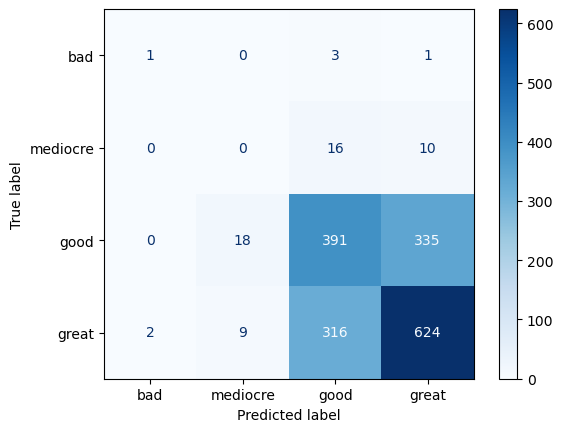

In [30]:
# Confusion Matrix - Decision Tree (Construção da Matriz de Confusão) 
Plot_Confusion_Matrix(Y_test, 
                      decision_tree_predicted,
                      labels=['bad', 'mediocre', 'good', 'great'])

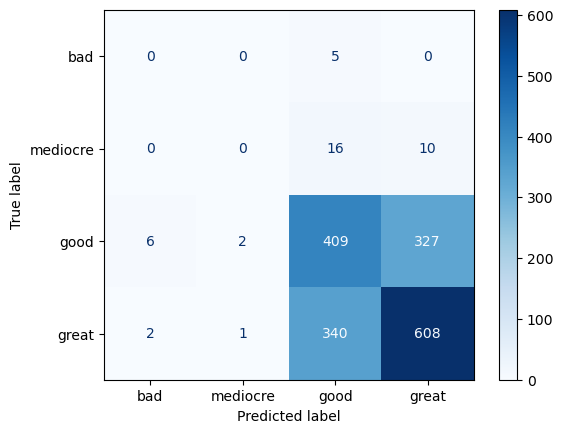

In [31]:
# Confusion Matrix - KNN (Construção da Matriz de Confusão)
Plot_Confusion_Matrix(Y_test,
                      knn_preds_test,
                      labels=['bad', 'mediocre', 'good', 'great'])

### <center>Precision, Recall, Accuracy</center>

In [32]:
# Precision, Recall and Accuracy given the predictive models initially obtained
data = [
        [precision_score(Y_test,decision_tree_predicted,average='macro')*100,
         recall_score(Y_test,decision_tree_predicted,average='macro')*100,
         accuracy_score(Y_test,decision_tree_predicted)*100],
        
        [precision_score(Y_test,knn_preds_test,average='macro')*100,
         recall_score(Y_test,knn_preds_test,average='macro')*100,
         accuracy_score(Y_test,knn_preds_test)*100]
       ]

# Criação de um DataFrame cujos dados correspondem à precision, recall e accuracy 
# dos algoritmos de aprendizagem computacional supervisionados
Evaluation_df = pd.DataFrame(data,
                             columns=['Precision (%)',
                                      'Recall/Sensitivity (%)',
                                      'Accuracy (%)'],
                             index=['Decision Tree', 'KNN'])
Evaluation_df

,Precision (%),Recall/Sensitivity (%),Accuracy (%)
Decision Tree,37.879995,34.542226,58.864426
KNN,29.363877,29.726455,58.922364


### <center>Performance</center><p><center>(Using K-Fold Cross Validation)</center>

-> Decision Tree Accuracy Avg: 53.915 (Std: 6.906)



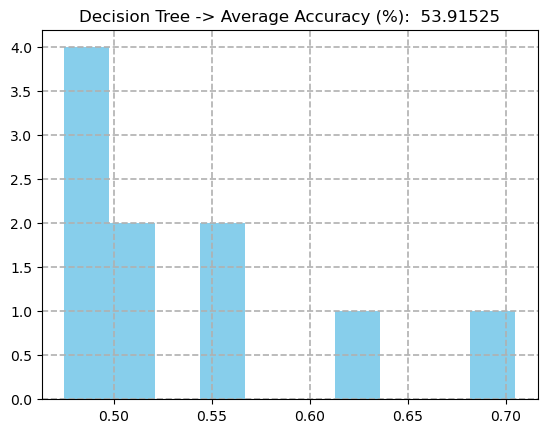

In [33]:
# DT Average Score/Accuracy (Cross Validation With Kfold)
DT_K_Fold_CV_Scores = Plot_Model_K_Fold_Cross_Validation("Decision Tree",decision_tree,X,Y,"skyblue")

-> KNN Accuracy Avg: 58.086 (Std: 8.770)



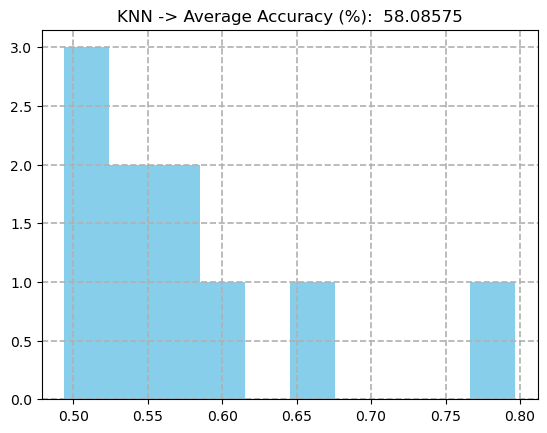

In [34]:
# KNN Average Score/Accuracy (Cross Validation With Kfold)
KNN_K_Fold_CV_Scores = Plot_Model_K_Fold_Cross_Validation("KNN",knn,X,Y,"skyblue")

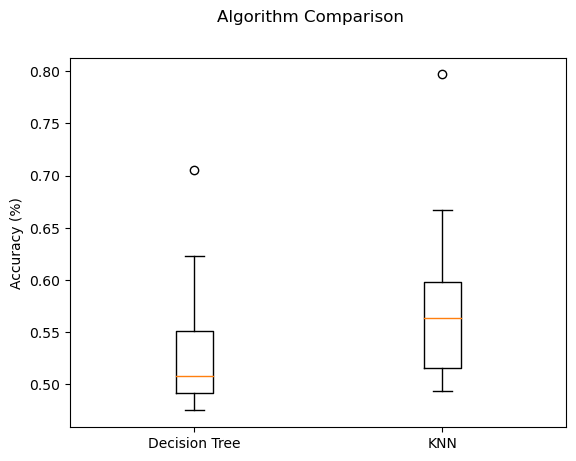

In [35]:
# Simple BoxPlot with both algorithm's accuracies (calculated above)
X_labels = ['Decision Tree', 'KNN']
Y_label = 'Accuracy (%)'
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot([DT_K_Fold_CV_Scores, KNN_K_Fold_CV_Scores])
ax.set_xticklabels(X_labels)
plt.ylabel(Y_label)
plt.show()

# <center>Parameter Tunning (Grid Search)</center>

## <center>Decision Tree Classifier</center>

In [38]:
# Finding the Best Possible Configuration for the DT_Classifier 
STRATIGY = None
decision_tree = Find_Best_DT_Classifier(X,Y,stratigy=STRATIGY)
Save_Tree_Diagram("Best_DT_Classifier", decision_tree)

Best Score (%):
  -> 55.7094
Best Parameters:
  -> criterion = gini
  -> max_depth = 4
  -> max_features = 2
  -> splitter = random


### - Decision Tree Diagram

<center><img src="Images/Best_Decision_Tree_Model.png" width="2000" title="Decision Tree"></center>

## <center>KNN Classifier</center>

In [39]:
# Finding the Best Possible Configuration for the KNN_Classifier 
knn = Find_Best_KNN_Classifier(X,Y,num_neighbors=N_NEIGHBORS,stratigy=STRATIGY)

Best Score (%):
  -> 24.4225
Best Parameters:
  -> leaf_size = 40
  -> metric = chebyshev
  -> n_neighbors = 1
  -> p = 1
  -> weights = uniform
